In [3]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from Dissertation import RandomGenerator, convert_to_int, get_order_index
from functools import partial
from scipy.stats import f, ncf
from sklearn.metrics import r2_score
from tqdm.notebook import trange
from utils import *
from estimators import ClusteredSegmentation

# Simluation

In [16]:
def sim(p, n, sample_name):
    test_result = []
    sample = sample_name
    rg = RandomGenerator(p, n, order_by = 'var', use_dask = False, verbose= False)
    X = rg._X.loc[:,rg._X.columns.str.contains('X')].apply(convert_to_int, axis = 1).to_numpy().reshape(-1,1)
    y = rg()['y'].to_numpy().reshape(-1,1)
    start = rg.config.parameter_size + 10
    end   = 5
    n = start
    cluster = ClusteredSegmentation(n_clusters = n)
    rg_config = [rg.config.sigma, rg.config.coefficient_generator_config]
    for i in range(start- end + 1):
        cluster.fit(X, y)
        if i == 0:
            rg_config.append(cluster.mse_full)
        tau = cluster.tau_metric
        test_result.append((cluster.MSE, tau.r_sqr, tau.tau_est, tau.tau_LB, tau.q, tau.r_sqf, sample, start - 10))
        n -= 1
        cluster.set_params(n_clusters = n)
    return test_result, rg_config

In [17]:
from joblib import Parallel, delayed
res = Parallel(n_jobs = -1, verbose = 1)(
    delayed(sim)(p = 10, n = 10_000, sample_name = f'sample_{i}') for i in range(10)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:  2.9min remaining: 11.8min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.0min finished


In [19]:
columns = ['MSE','rsq','tau','tau_lb', 'num_segments', 'rsq_full', 'sample', 'true_segment']
test_result = res[0][0]
for i in range(1, 10):
    test_result = test_result + res[i][0]
result = pd.DataFrame(test_result, columns = columns)

In [20]:
result.true_segment.unique()

array([202, 127, 229, 200,  84, 285, 184, 217, 215, 102])

In [21]:
result.rsq_full.unique()

array([0.98253162, 0.96921756, 0.93022691, 0.98037369, 0.95360195,
       0.98525795, 0.94329616, 0.95127515, 0.97745189, 0.94602693])

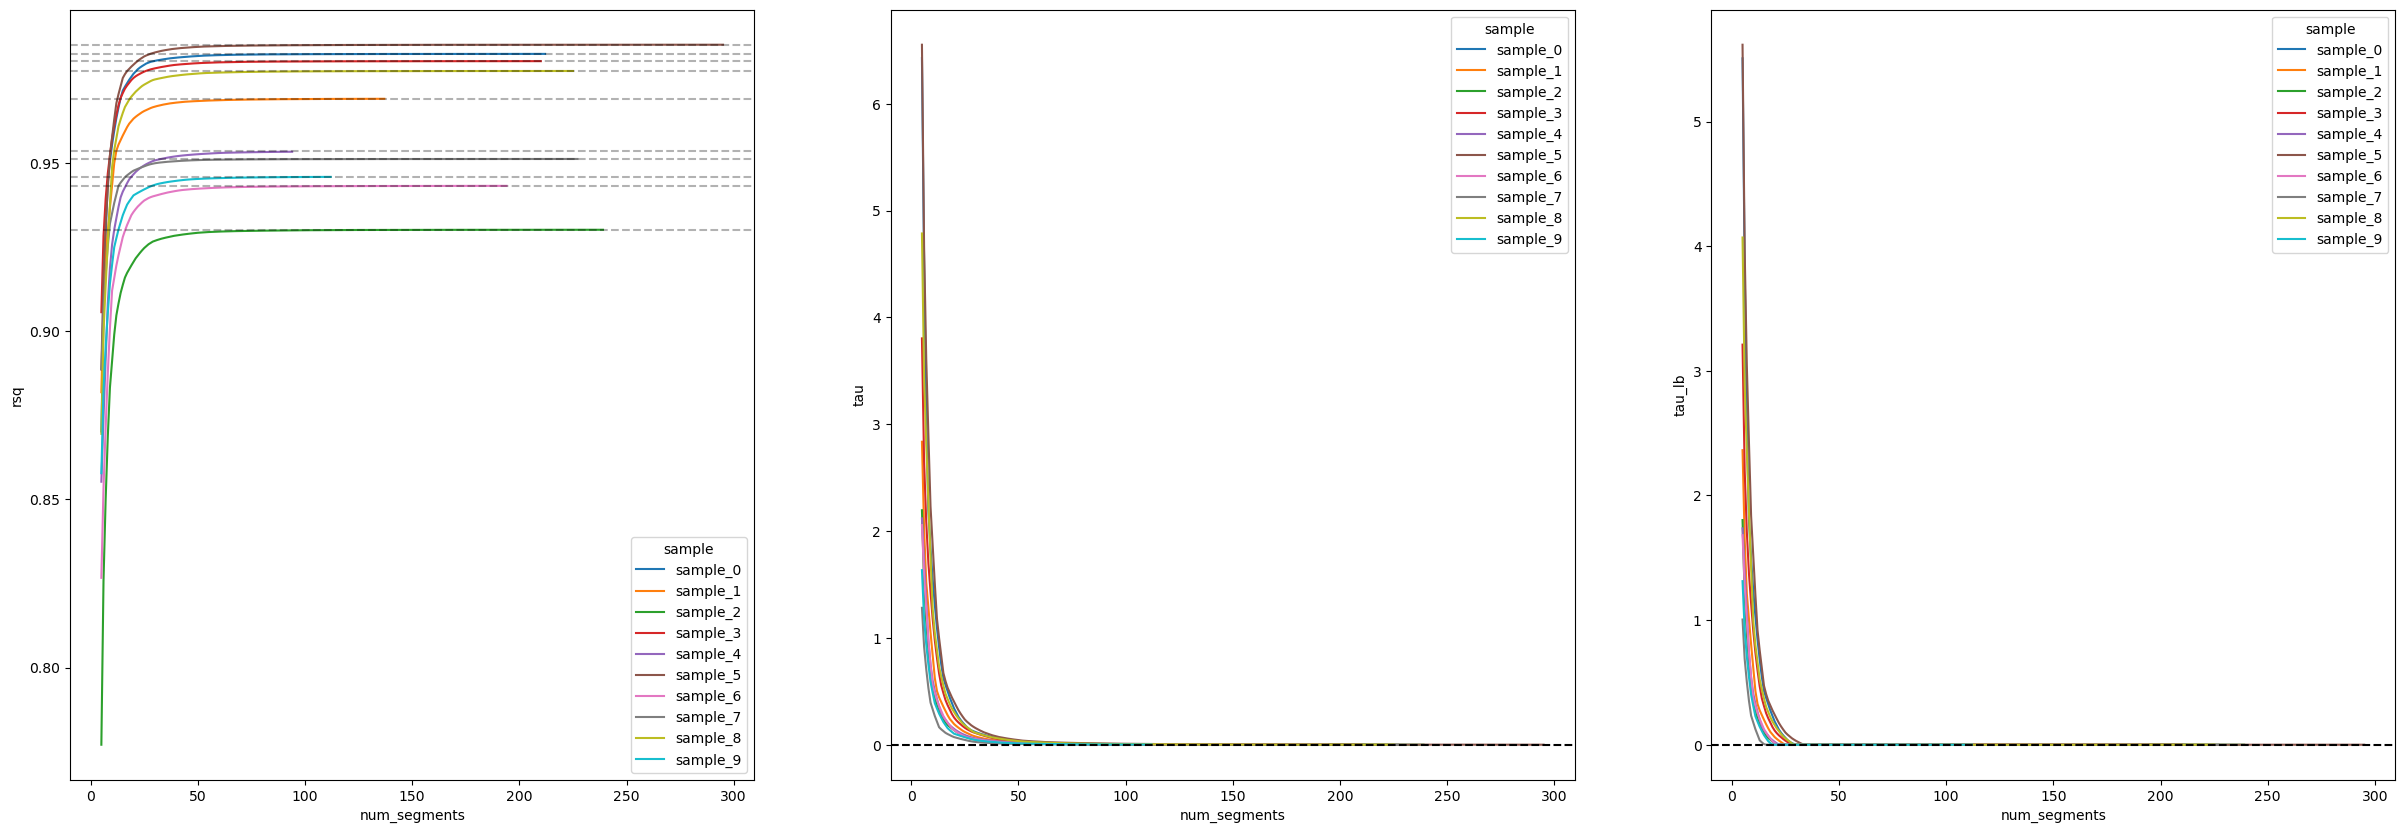

In [22]:
fig, ax = plt.subplots(1, 3, figsize = (30, 10))
sns.lineplot(data = result, x = 'num_segments', y = 'rsq', hue = 'sample', ax = ax[0])
sns.lineplot(data = result, x = 'num_segments', y = 'tau', hue = 'sample', ax = ax[1])
sns.lineplot(data = result, x = 'num_segments', y = 'tau_lb', hue = 'sample', ax = ax[2])
for rsq_full in result.rsq_full.unique():
    ax[0].axhline(rsq_full, c = 'black', linestyle = '--', alpha = .3)
ax[1].axhline(0, c = 'black', linestyle = '--')
ax[2].axhline(0, c = 'black', linestyle = '--')
plt.savefig('result.png')
plt.show()

# Simulation 2 : Performance of the model with test data

In this simulation, we tested how well the model performs with respect to the testing dataset. After drawing random datasets, they are split into train and test dataset with 4:1 ratio. The models are fit with the train dataset, and $R^2$ is obtained not only from the train but also from the test dataset. 

In [23]:
from sklearn.model_selection import train_test_split

In [52]:
def sim(p, n, cluster_size):
    rg = RandomGenerator(p, n, order_by = 'var', use_dask = False, verbose= False)
    X = rg._X.loc[:,rg._X.columns.str.contains('X')].apply(convert_to_int, axis = 1).to_numpy().reshape(-1,1)
    y = rg()['y'].to_numpy().reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  .20)
    cluster = ClusteredSegmentation(n_clusters = cluster_size)
    cluster.fit(X_train, y_train)
    num_missing = 2**10 - cluster.full_to_reduced.shape[0]
    tau = cluster.tau_metric
    y_pred_exist = []
    y_test_exist = []
    for i, x in enumerate(X_test.reshape(-1)):
        try:
            y_pred_exist.append(cluster.predict(x))
            y_test_exist.append(y_test[i][0])
        except:
            pass
    test_r2 = r2_score(y_test_exist, y_pred = y_pred_exist)
    mse = cluster.MSE
    return rg.config.parameter_size, tau.r_sqf, tau.r_sqr, tau.tau_est, test_r2, rg.config.sigma, np.sqrt(mse), rg.config.coefficient_generator_config['mean'], rg.config.coefficient_generator_config['error'], num_missing

In [53]:
from joblib import Parallel, delayed
res = Parallel(n_jobs = -1, verbose = 1)(
    delayed(sim)(p = 10, n = 12_500, cluster_size = 10) for i in range(500)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.4min finished


In [54]:
result = pd.DataFrame(res, columns = ['parameter_size','r2f','r2r','tau_est','test_r2', 'sigma', 'sigma_est', 'coef_mean','coef_error', 'num_missing'])

result = result.sort_values('r2f', ascending=False).reset_index(drop = True)

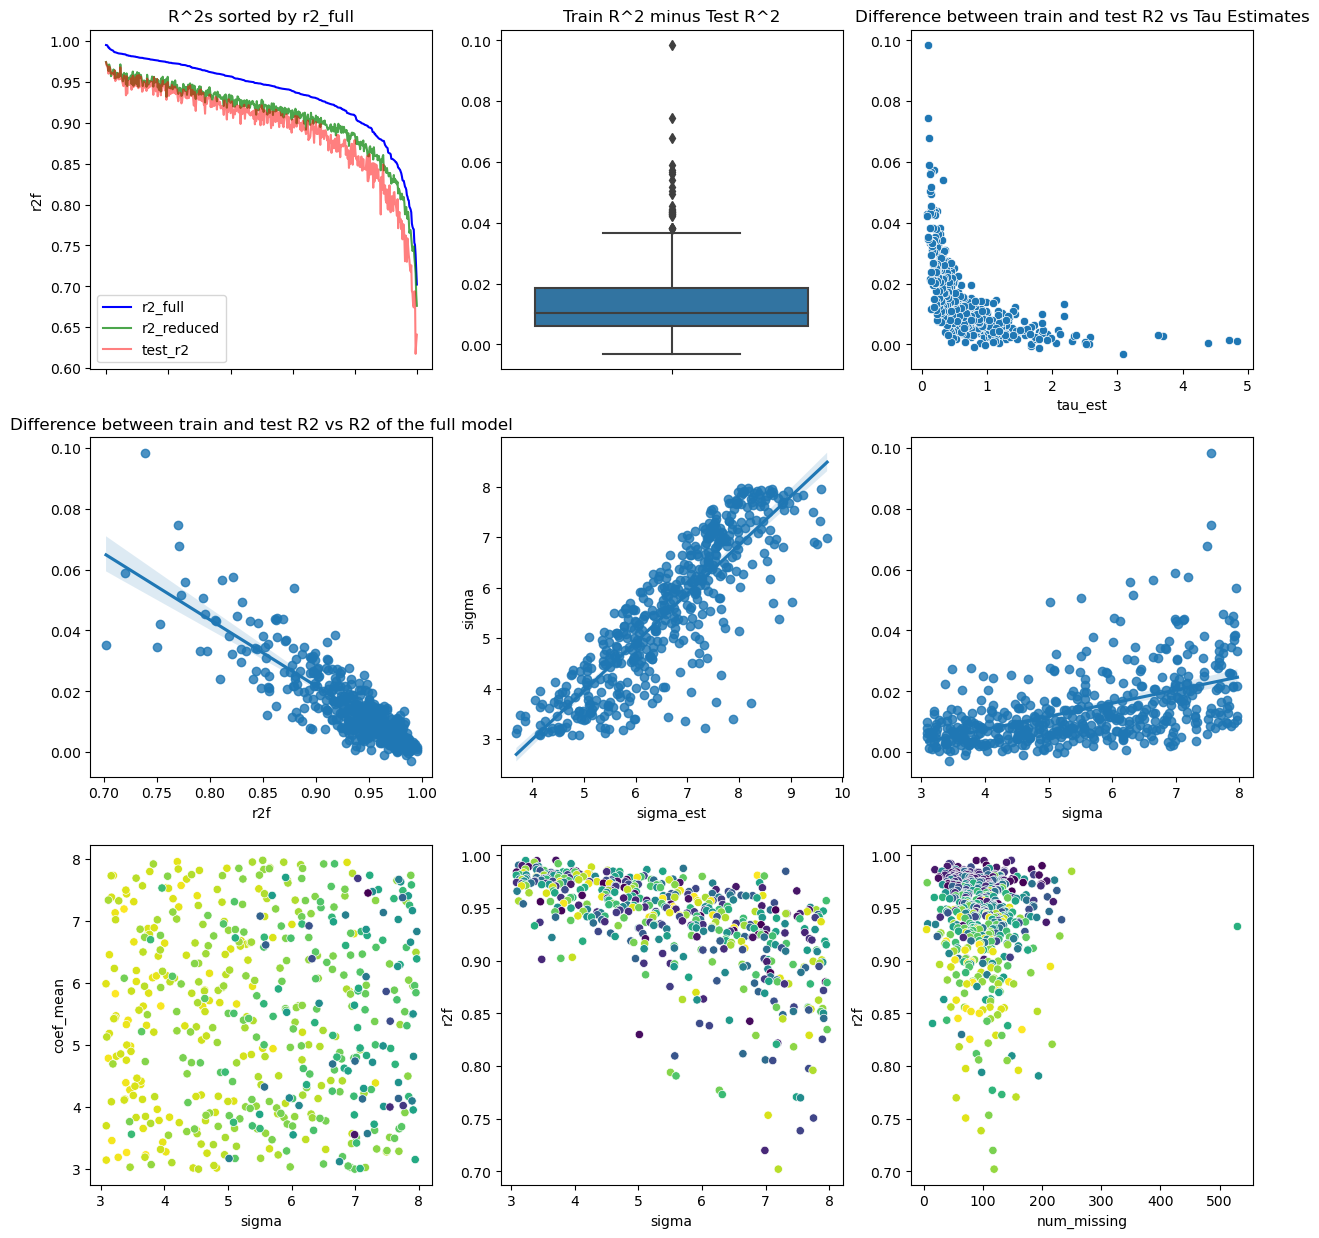

In [57]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize = (15, 15))
sns.lineplot(data = result, x = result.index, y = 'r2f', color = 'blue', ax = ax1, label = 'r2_full')
sns.lineplot(data = result, x = result.index, y = 'r2r', color = 'green', alpha = .7, ax = ax1, label = 'r2_reduced')
sns.lineplot(data = result, x = result.index, y = 'test_r2', color = 'red', alpha = .5, ax = ax1, label= 'test_r2')
sns.boxplot(y = result.r2r - result.test_r2, ax = ax2)
# sns.scatterplot(data = result, x = 'parameter_size', y = 'tau_est', size = .5, color = 'y', ax = ax3)
sns.scatterplot(data = result, x = 'tau_est', y = result.r2r - result.test_r2, ax = ax3)
sns.regplot(data = result, x = 'r2f', y = result.r2r - result.test_r2, ax = ax4)
# sns.regplot(data = result, x = 'sigma', y = 'r2f', ax = ax5)
sns.regplot(data = result, x = 'sigma_est', y = 'sigma', ax = ax5)
sns.regplot(data = result, x = 'sigma', y = result.r2r - result.test_r2, ax = ax6)

sns.scatterplot(data = result, x = 'sigma',y = 'coef_mean', c = result.r2f, ax = ax7)
sns.scatterplot(data = result, x = 'sigma',y = 'r2f', c = result.coef_mean, ax = ax8)
sns.scatterplot(data = result, x = 'num_missing',y = 'r2f', c = result.sigma, ax = ax9)
ax1.set_xticklabels("")
ax1.legend()
ax1.set_title('R^2s sorted by r2_full')
ax2.set_title('Train R^2 minus Test R^2')
ax3.set_title("Difference between train and test R2 vs Tau Estimates")
ax4.set_title("Difference between train and test R2 vs R2 of the full model")
plt.show()

#### When we increase the cluster size to 20

In [58]:
res = Parallel(n_jobs = -1, verbose = 1)(
    delayed(sim)(p = 10, n = 12_500, cluster_size = 20) for i in range(500)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.4min finished


In [59]:
result = pd.DataFrame(res, columns = ['parameter_size','r2f','r2r','tau_est','test_r2', 'sigma', 'sigma_est', 'coef_mean','coef_error', 'num_missing'])
result = result.sort_values('r2f', ascending=False).reset_index(drop = True)

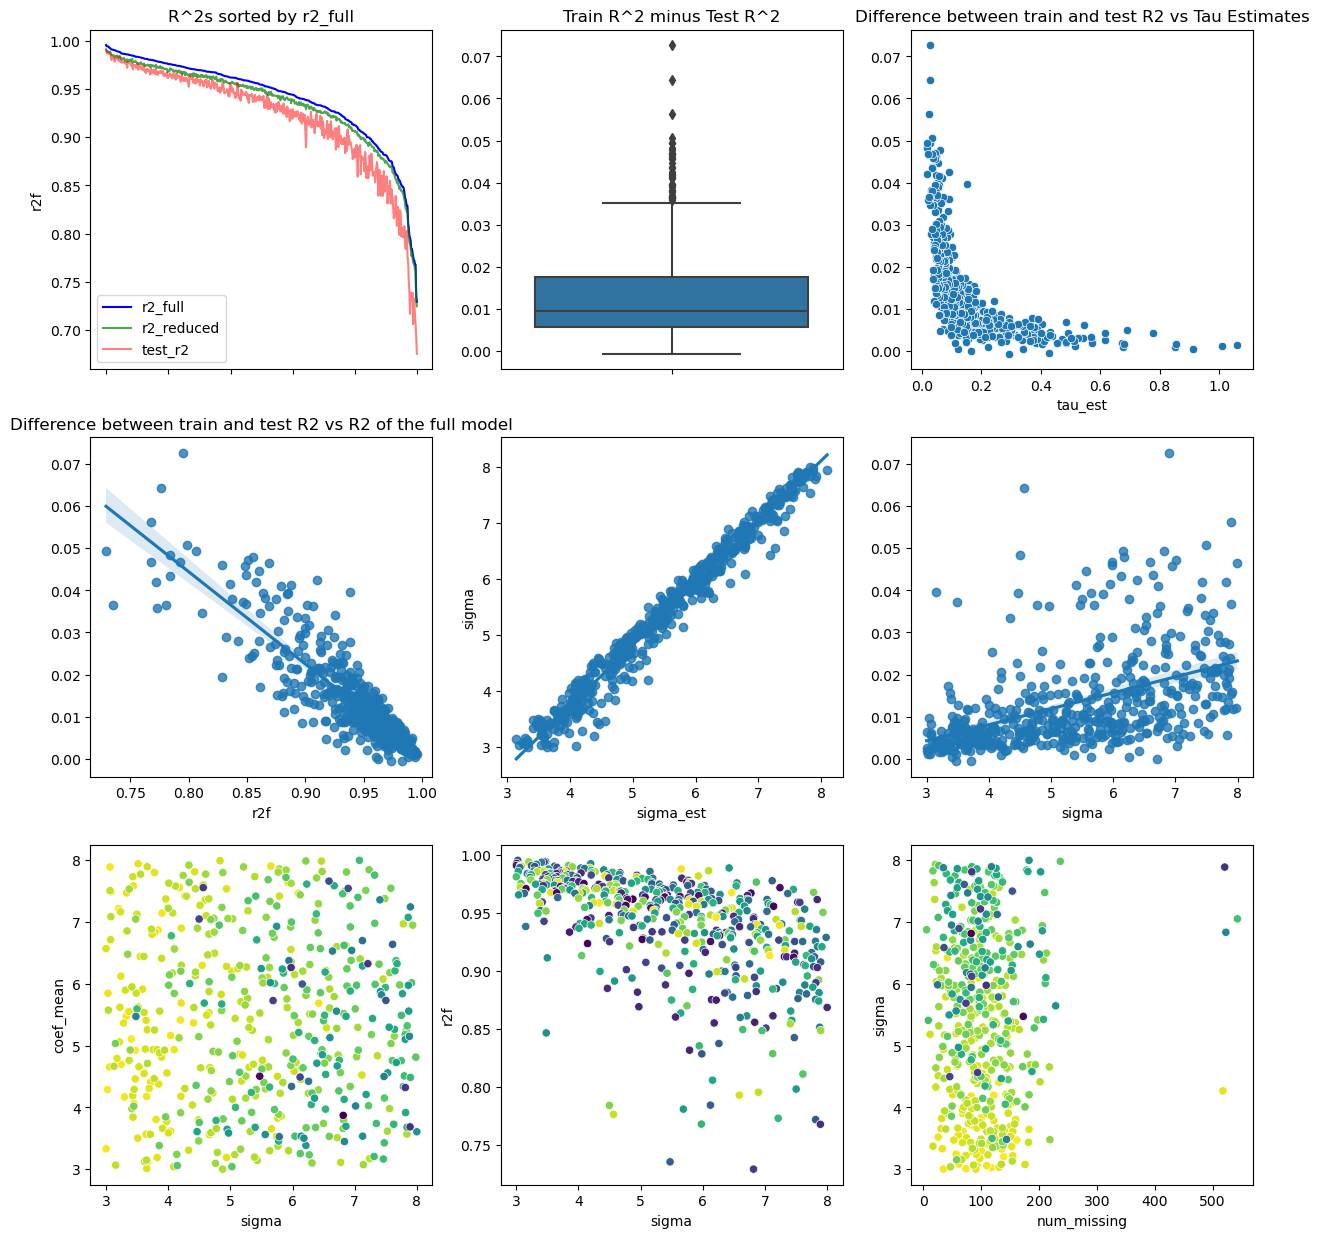

In [60]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize = (15, 15))
sns.lineplot(data = result, x = result.index, y = 'r2f', color = 'blue', ax = ax1, label = 'r2_full')
sns.lineplot(data = result, x = result.index, y = 'r2r', color = 'green', alpha = .7, ax = ax1, label = 'r2_reduced')
sns.lineplot(data = result, x = result.index, y = 'test_r2', color = 'red', alpha = .5, ax = ax1, label= 'test_r2')
sns.boxplot(y = result.r2r - result.test_r2, ax = ax2)
# sns.scatterplot(data = result, x = 'parameter_size', y = 'tau_est', size = .5, color = 'y', ax = ax3)
sns.scatterplot(data = result, x = 'tau_est', y = result.r2r - result.test_r2, ax = ax3)
sns.regplot(data = result, x = 'r2f', y = result.r2r - result.test_r2, ax = ax4)
# sns.regplot(data = result, x = 'sigma', y = 'r2f', ax = ax5)
sns.regplot(data = result, x = 'sigma_est', y = 'sigma', ax = ax5)
sns.regplot(data = result, x = 'sigma', y = result.r2r - result.test_r2, ax = ax6)

sns.scatterplot(data = result, x = 'sigma',y = 'coef_mean', c = result.r2f, ax = ax7)
sns.scatterplot(data = result, x = 'sigma',y = 'r2f', c = result.coef_mean, ax = ax8)
sns.scatterplot(data = result, x = 'num_missing',y = 'sigma', c = result.r2f, ax = ax9)
ax1.set_xticklabels("")
ax1.legend()
ax1.set_title('R^2s sorted by r2_full')
ax2.set_title('Train R^2 minus Test R^2')
ax3.set_title("Difference between train and test R2 vs Tau Estimates")
ax4.set_title("Difference between train and test R2 vs R2 of the full model")
plt.show()

#### At the true parameter size

In [15]:
def sim(p, n):
    rg = RandomGenerator(p, n, order_by = 'var', use_dask = False, verbose= False)
    X = rg._X.loc[:,rg._X.columns.str.contains('X')].apply(convert_to_int, axis = 1).to_numpy().reshape(-1,1)
    y = rg()['y'].to_numpy().reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  .20)
    cluster = ClusteredSegmentation(n_clusters = rg.config.parameter_size)
    cluster.fit(X_train, y_train)
    tau = cluster.tau_metric
    y_pred_exist = []
    y_test_exist = []
    for i, x in enumerate(X_test.reshape(-1)):
        try:
            y_pred_exist.append(cluster.predict(x))
            y_test_exist.append(y_test[i][0])
        except:
            pass
    test_r2 = r2_score(y_test_exist, y_pred = y_pred_exist)
    mse = cluster.MSE
    return rg.config.parameter_size, tau.r_sqf, tau.r_sqr, tau.tau_est, test_r2, rg.config.sigma, np.sqrt(mse)

In [16]:
res = Parallel(n_jobs = -1, verbose = 1)(
    delayed(sim)(p = 10, n = 12_500) for i in range(500)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.4min finished


In [17]:
result = pd.DataFrame(res, columns = ['parameter_size','r2f','r2r','tau_est','test_r2', 'sigma','sigma_est'])
result = result.sort_values('r2f', ascending=False).reset_index(drop = True)

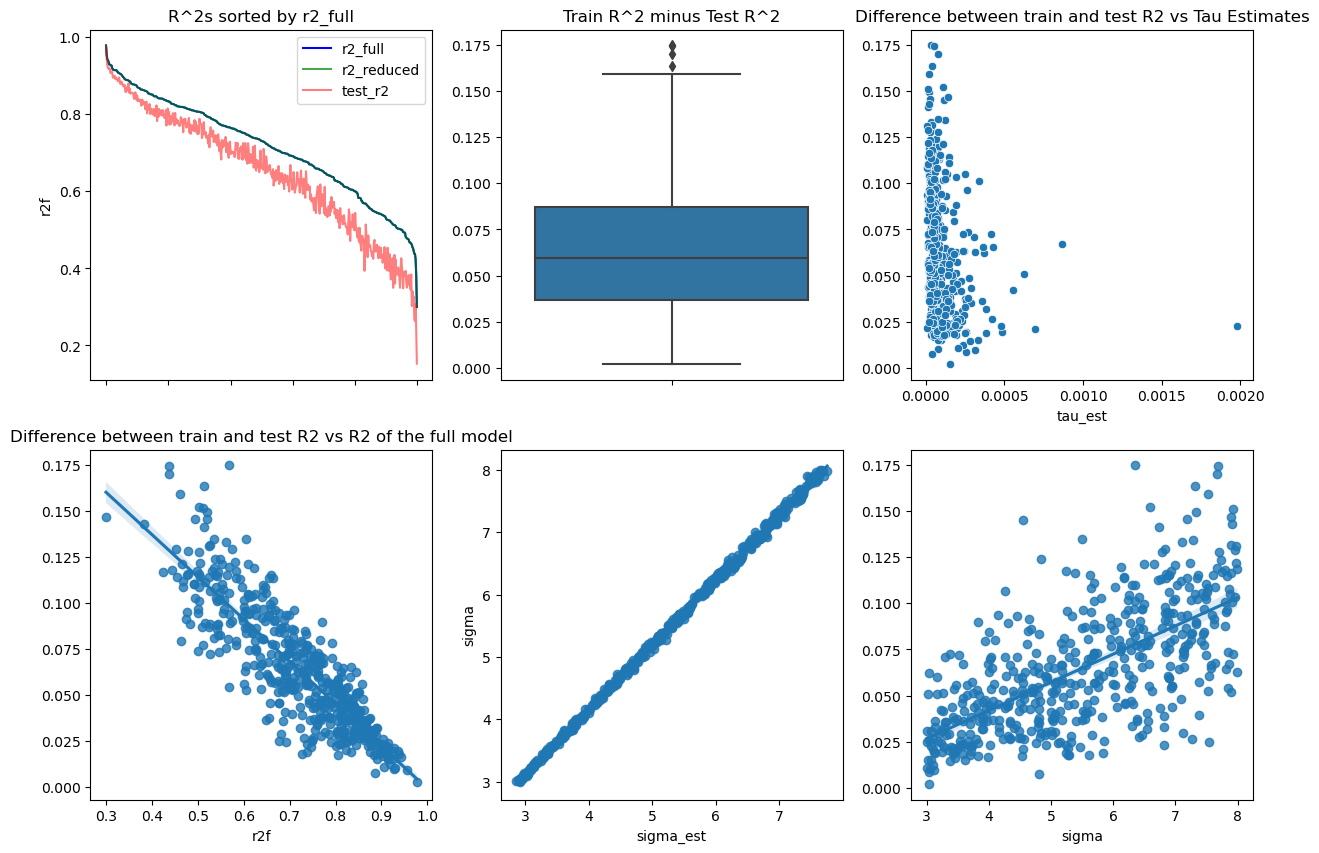

In [18]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (15, 10))
sns.lineplot(data = result, x = result.index, y = 'r2f', color = 'blue', ax = ax1, label = 'r2_full')
sns.lineplot(data = result, x = result.index, y = 'r2r', color = 'green', alpha = .7, ax = ax1, label = 'r2_reduced')
sns.lineplot(data = result, x = result.index, y = 'test_r2', color = 'red', alpha = .5, ax = ax1, label= 'test_r2')
sns.boxplot(y = result.r2r - result.test_r2, ax = ax2)
# sns.scatterplot(data = result, x = 'parameter_size', y = 'tau_est', size = .5, color = 'y', ax = ax3)
sns.scatterplot(data = result, x = 'tau_est', y = result.r2r - result.test_r2, ax = ax3)
sns.regplot(data = result, x = 'r2f', y = result.r2r - result.test_r2, ax = ax4)
# sns.regplot(data = result, x = 'sigma', y = 'r2f', ax = ax5)
sns.regplot(data = result, x = 'sigma_est', y = 'sigma', ax = ax5)
sns.regplot(data = result, x = 'sigma', y = result.r2r - result.test_r2, ax = ax6)

ax1.set_xticklabels("")
ax1.legend()
ax1.set_title('R^2s sorted by r2_full')
ax2.set_title('Train R^2 minus Test R^2')
ax3.set_title("Difference between train and test R2 vs Tau Estimates")
ax4.set_title("Difference between train and test R2 vs R2 of the full model")
plt.show()

# Unseen Pairs (by Dec 15)

In [4]:
p, n = 10, 15_000
rg = RandomGenerator(p, n, order_by = 'var', use_dask = False, verbose= False)
X = rg._X.loc[:,rg._X.columns.str.contains('X')].apply(convert_to_int, axis = 1).to_numpy().reshape(-1,1)
y = rg()['y'].to_numpy().reshape(-1,1)
cluster = ClusteredSegmentation(n_clusters = 10)
cluster.fit(X, y)
tau = cluster.tau_metric


In [5]:
cluster.full_to_reduced.shape[0]

995

In [6]:
cluster.set_params(n_clusters = 40)
cluster.fit(X, y)

ClusteredSegmentation(n_clusters=40)

In [7]:
rg.config.coefficient_generator_config

{'distribution': 'Gauss',
 'mean': 3.1474189675118476,
 'error': 5.469726258620929}

In [8]:
cluster.mse_full

56.612083487299664

In [9]:
cluster.MSE

53.463346323986215

In [10]:
rg.config.sigma**2

56.53565920483302

In [11]:
rg.config.sigma

7.519019830059834

In [12]:
tau.tau_est

0.18408228280256836

In [13]:
tau

tau(n=15000, p=1024, q=10, r_sqf=0.8332571306748451, r_sqr=0.8025627226484202, alpha=0.05)

In [14]:
from BarcodeScanner import barcodeScanner
scanner = barcodeScanner(estimator = cluster, config = rg.config)
scanner.raw_contrast, scanner.missingPairsMLE()

(<955x1024 sparse matrix of type '<class 'numpy.int8'>'
 	with 59629 stored elements in COOrdinate format>,
 <29x1024 sparse matrix of type '<class 'numpy.int8'>'
 	with 29 stored elements in Compressed Sparse Column format>)

In [16]:
table = cluster.full_to_reduced.reset_index(drop = False).sort_values('reduced')

In [17]:
table['count'] = table.full.apply(lambda x: np.where(X.reshape(-1) == x)[0].shape[0])

In [18]:
table

,full,reduced,count
960,989,0,3
835,861,1,2
553,575,1,2
897,925,1,8
956,985,2,9
...,...,...,...
911,939,38,7
978,1007,39,3
866,894,39,3
490,511,39,2


In [19]:
table['barcode'] = table.apply(lambda x: scanner.num_to_barcode(x['full'], 10).toarray()[0], axis = 1)

In [20]:
table['barcode'].apply(lambda x: len(x)).unique()

array([10])

In [21]:
reduced = []
weighted_mean = []
for r in table.reduced.unique():
    r_table = table.loc[table.reduced.eq(r), ['barcode','count']]
    reduced.append(r)
    weighted_mean.append(np.average(r_table.barcode.values, weights = r_table['count']))

In [22]:
missing = scanner.num_to_barcode(scanner.missing_pairs_decimal_repr[0], 10).toarray().reshape(-1)

#### Euclidean Distance

In [23]:
from scipy.spatial.distance import euclidean

In [24]:
euclidean_distance = [euclidean(x, missing) for x in weighted_mean]

In [25]:
euclidean_distance.index(min(euclidean_distance))

36

#### mahalanobis distance

In [89]:
from sklearn.covariance import EmpiricalCovariance

In [90]:
X_list = [scanner.num_to_barcode(x, 10).toarray()[0].tolist() for x  in X.reshape(-1)]

In [91]:
covs = []
for r in table.reduced.unique():
    barcodes = []
    r_table = table.loc[table.reduced.eq(r), ['barcode','count']]
    for b, c in zip(r_table.barcode, r_table['count']):
        barcodes += [b for _ in range(c)]
    barcodes = np.concatenate(barcodes).reshape(-1, 10)
    cov = EmpiricalCovariance()
    cov.fit(barcodes)
    covs.append(cov)

In [29]:
m_dist = [cov.mahalanobis(missing.reshape(1,-1))[0] for cov in covs]

In [30]:
non_zero_min = min([x  for x in m_dist if x>0])

In [31]:
m_dist.index(non_zero_min)

1

In [32]:
from numpy.linalg import inv
from scipy.spatial.distance import mahalanobis

In [33]:
cov = EmpiricalCovariance()
cov.fit(X_list)

EmpiricalCovariance()

In [34]:
pooled_var = [mahalanobis(w, missing.reshape(-1), inv(cov.covariance_)) for w in weighted_mean]

In [35]:
pooled_var.index(min(pooled_var))

36

In [37]:
m_dist[36], m_dist[1]

(5.447342969412636, 0.7142857142857144)

#### Johnson-Shannon distance

In [38]:
len(X_list)

15000

In [39]:
table.reduced.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

In [40]:
r = 2
selected_table = table.loc[table.reduced.eq(r),:]

In [41]:
selected_table

,full,reduced,count,barcode
956,985,2,9,"[1, 1, 1, 1, 0, 1, 1, 0, 0, 1]"
583,605,2,2,"[1, 0, 0, 1, 0, 1, 1, 1, 0, 1]"
771,797,2,7,"[1, 1, 0, 0, 0, 1, 1, 1, 0, 1]"
237,250,2,5,"[0, 0, 1, 1, 1, 1, 1, 0, 1, 0]"
45,47,2,2,"[0, 0, 0, 0, 1, 0, 1, 1, 1, 1]"
615,637,2,3,"[1, 0, 0, 1, 1, 1, 1, 1, 0, 1]"
676,700,2,12,"[1, 0, 1, 0, 1, 1, 1, 1, 0, 0]"
535,557,2,6,"[1, 0, 0, 0, 1, 0, 1, 1, 0, 1]"
485,506,2,1,"[0, 1, 1, 1, 1, 1, 1, 0, 1, 0]"
708,733,2,2,"[1, 0, 1, 1, 0, 1, 1, 1, 0, 1]"


In [46]:
wm = weighted_mean[2]

In [47]:
from itertools import product

In [48]:
all_comb = list(product(range(2), repeat=10))

In [50]:
wm

array([0.83673469, 0.34693878, 0.59183673, 0.44897959, 0.59183673,
       0.83673469, 1.        , 0.69387755, 0.16326531, 0.63265306])

In [71]:
probability_sequence = []
for com in all_comb:
    prob_list = [y if x > 0 else 1-y for x, y in zip(com, wm)]
    probability_sequence.append(reduce(lambda x, y : x * y, prob_list))

In [73]:
sum(probability_sequence)

1.0000000000000004

In [77]:
tuple(missing)

(1, 1, 1, 1, 1, 0, 0, 0, 1, 1)

In [83]:
g = np.zeros(len(probability_sequence), dtype = np.byte)
g[all_comb.index(tuple(missing))] = 1

In [85]:
from scipy.spatial.distance import jensenshannon

In [87]:
jensenshannon(probability_sequence, g)

0.8325546111576978

# Performance on testing dataset (maybe including unseen pairs)